In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import mode
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import optuna

In [56]:
data = pd.read_csv('./train.csv')

In [57]:
# т.к. пропущенных данных не много, то заменим их модой
edu_moda = mode(data.education)[0][0]
data.education.fillna(edu_moda, inplace=True)
#data.drop('client_id', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73799 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [58]:
def preprocessing(data):
    # бинарные переменные
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
    # категориальные переменные
    cat_cols = ['education', 'home_address', 'work_address']
    # числовые переменные
    num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

    # обработка бинарных переменных
    X_bin = []
    for col in bin_cols:
        X_bin.append(LabelEncoder().fit_transform(data[col].values))
    X_bin = np.array(X_bin).T
    # обработка категориальных переменных
    X_cat = OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)
    # Логарифмирование и стандартизация числовых переменных
    X_num = StandardScaler().fit_transform(np.log(data[num_cols]+1).values)
    
    # объединим стандартизованные числовые, бинарные и закодированные категориальные переменные
    # в одно признаковое пространство
    X = np.hstack([X_num, X_bin, X_cat])
    y = data['default'].values
    
    return X, y

In [59]:
def plot_roc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12,8), facecolor='w')
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
def report(y_true, y_pred):
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print('Confusion matrix')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

In [60]:
X, y = preprocessing(data)
X.shape

(73799, 20)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [62]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.288829,-0.420012,0.772607,1.352893,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.776442,-0.420012,-1.334617,-0.785016,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.133479,-0.420012,0.335319,2.666190,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.288829,-0.420012,0.335319,3.468277,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.969897,-0.420012,1.111795,0.679253,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49440,-0.452411,-0.420012,2.005255,1.439784,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
49441,1.234766,-0.420012,-0.281005,-0.707526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
49442,1.234766,-0.420012,0.335319,-0.785016,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
49443,-0.452411,1.489652,1.111795,-0.052888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [63]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 0.01, log=True)
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    ## Create Model
    classifier = LogisticRegression(penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class="auto",
                                   )
    ## Fit Model
    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

In [64]:
%%time

study3 = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study3.optimize(objective, n_trials=15)

[I 2022-01-16 00:41:36,445] A new study created in memory with name: LogisticRegression
[I 2022-01-16 00:41:36,620] Trial 0 finished with value: 0.8731625195039829 and parameters: {'penalty': 'l2', 'tol': 0.0002568932672479344, 'C': 4.743451182765373, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8731625195039829.
[I 2022-01-16 00:41:36,782] Trial 1 finished with value: 0.8731625195039829 and parameters: {'penalty': 'l2', 'tol': 0.0003403158495890456, 'C': 2.3255602473273282, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8731625195039829.
[I 2022-01-16 00:41:38,362] Trial 2 finished with value: 0.8731625195039829 and parameters: {'penalty': 'l2', 'tol': 0.0015489458883933699, 'C': 2.634174791495732, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 0 with value: 0.8731625195039829.
[I 2022-01-16 00:41:39,163] Trial 3 finished with value: 0.8731625195039829 and parameters: {'penalty': 'l2', 'tol': 0.0001643174903605854

Wall time: 10.5 s


In [65]:
print("Best Params : {}".format(study3.best_params))

print("\nBest Accuracy : {}".format(study3.best_value))

Best Params : {'penalty': 'l2', 'tol': 0.0002568932672479344, 'C': 4.743451182765373, 'fit_intercept': False, 'solver': 'liblinear'}

Best Accuracy : 0.8731625195039829


In [66]:
classifier = LogisticRegression(**study3.best_params, multi_class="auto")

classifier.fit(X_train, y_train)

print("Logistic Regression Accuracy on Train Dataset : {}".format(classifier.score(X_train, y_train)))
print("Logistic Regression Accuracy on Test  Dataset : {}".format(classifier.score(X_test, y_test)))

Logistic Regression Accuracy on Train Dataset : 0.8728890686621499
Logistic Regression Accuracy on Test  Dataset : 0.8731625195039829


In [67]:
y_pred = classifier.predict(X_test)
report(y_test, y_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     21261
           1       0.67      0.00      0.01      3093

    accuracy                           0.87     24354
   macro avg       0.77      0.50      0.47     24354
weighted avg       0.85      0.87      0.81     24354

Confusion matrix
       0  1
0  21257  4
1   3085  8


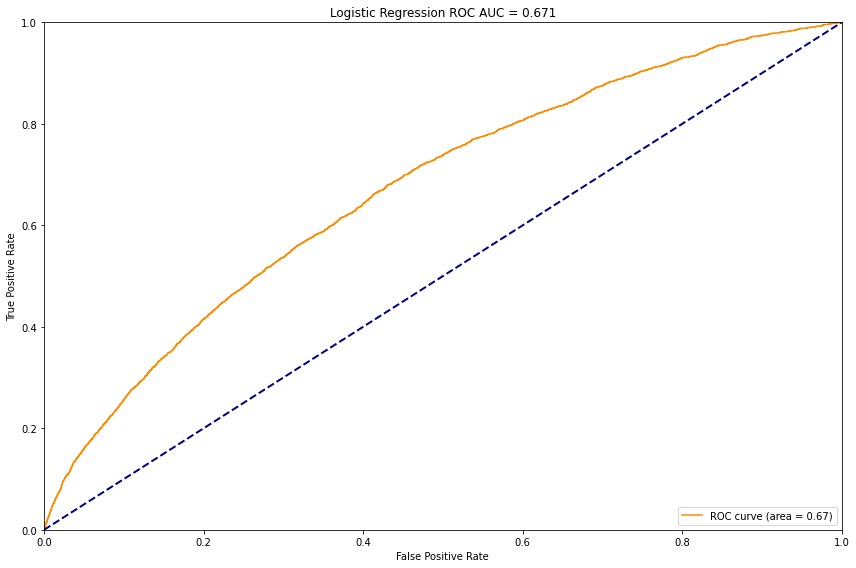

In [68]:
y_score = classifier.predict_proba(X_test)[:,1]
plot_roc(y_test, y_score)

In [69]:
classifier = LogisticRegression(multi_class="auto")

classifier.fit(X_train, y_train)

print("Logistic Regression Accuracy on Train Dataset : {}".format(classifier.score(X_train, y_train)))
print("Logistic Regression Accuracy on Test  Dataset : {}".format(classifier.score(X_test, y_test)))

Logistic Regression Accuracy on Train Dataset : 0.8728688441702902
Logistic Regression Accuracy on Test  Dataset : 0.8731625195039829


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
y_pred = classifier.predict(X_test)
report(y_test, y_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     21261
           1       0.67      0.00      0.01      3093

    accuracy                           0.87     24354
   macro avg       0.77      0.50      0.47     24354
weighted avg       0.85      0.87      0.81     24354

Confusion matrix
       0  1
0  21257  4
1   3085  8


In [71]:
%%time

param_grid = {
              "penalty": ["l1", "l2"],
              "C" : np.linspace(1, 10.0, 25),
              "fit_intercept": [True, False],
              "tol": np.linspace(0.0001, 0.01,10),
              "solver": ["liblinear", "saga"]
             }

grid = GridSearchCV(LogisticRegression(multi_class="auto", max_iter=500), param_grid, cv=5)

grid.fit(X_train, y_train)

grid.best_params_

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

Wall time: 1h 18min 8s


{'C': 1.0,
 'fit_intercept': True,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.0089}